In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

In [11]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    './train_and_test/train/', 
    subset='training',
    validation_split=0.2,
    image_size=(299,299),
    batch_size=32,
    seed=42
)

val = tf.keras.preprocessing.image_dataset_from_directory(
    './train_and_test/train/', 
    subset='validation',
    validation_split=0.2,
    image_size=(299,299),
    batch_size=32,
    seed=42
)

# test = tf.keras.preprocessing.image_dataset_from_directory(
#     './train_and_test/test/Electronic', 
#     subset='validation',
#     validation_split=0.2,
#     image_size=(299,299),
#     batch_size=32,
#     seed=42
# )

Found 116958 files belonging to 10 classes.
Using 93567 files for training.
Found 116958 files belonging to 10 classes.
Using 23391 files for validation.


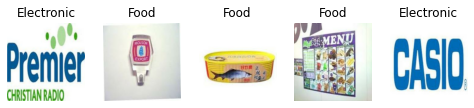

In [12]:
plt.figure(figsize=(10, 10))
class_names = train.class_names
for images, labels in train.take(1):
    for i in range(5):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
from keras.applications.inception_v3 import preprocess_input, decode_predictions, InceptionV3

base_model = InceptionV3(include_top=False, weights='imagenet')
base_model.trainable=False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_4[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_95 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                    

In [14]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime
tf.random.set_seed(42)

%load_ext tensorboard

file_path='weights.best.hdf5'

checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

def decay(epoch):
  if epoch < 3:
    return 1e-4
  elif epoch >= 9 and epoch < 24:
    return 1e-5
  else:
    return 1e-6

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(decay)

callbacks_list = [checkpoint, early, tensorboard_callback, lr_scheduler]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [15]:
inputs = keras.Input(shape=(299,299,3,))
inputs = preprocess_input(inputs)

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [16]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train, epochs=1, validation_data=val, callbacks=callbacks_list)

1101/2924 [==========>...................] - ETA: 38:43 - loss: 2.2817 - accuracy: 0.2499

KeyboardInterrupt: 